In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
import matplotlib.pyplot as plt
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
import os
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB1
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from sklearn.metrics import classification_report,confusion_matrix
import ipywidgets as widgets
import io
from PIL import Image
from IPython.display import display,clear_output
from warnings import filterwarnings

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


# **Data Preperation**

In [2]:
labels = ['glioma_tumor','no_tumor','meningioma_tumor','pituitary_tumor']

In [3]:
X_train = [] #For Images
y_train = [] #For storing labels
image_size = 224
for i in labels:
    folderPath = os.path.join('Training',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size, image_size))
        X_train.append(img)
        y_train.append(i)
        
for i in labels:
    folderPath = os.path.join('Testing',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size,image_size))
        X_train.append(img)
        y_train.append(i)
        
X_train = np.array(X_train)
y_train = np.array(y_train)

100%|██████████████████████████████████████████████████████████████████████████████████| 74/74 [00:01<00:00, 73.47it/s]


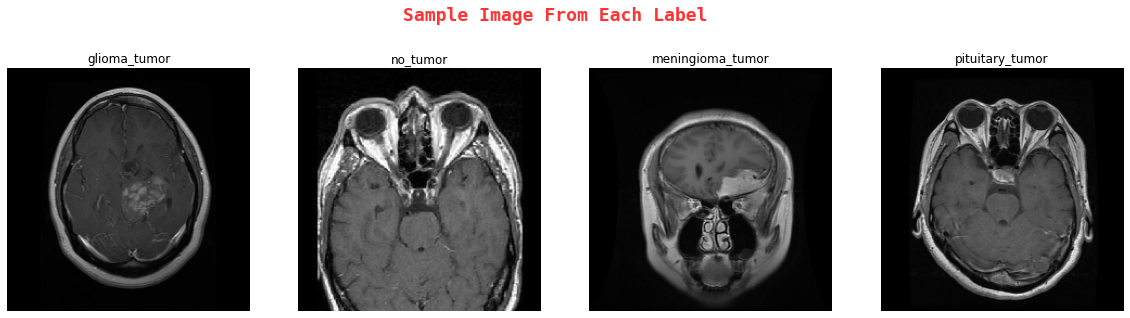

In [4]:
k=0
fig, ax = plt.subplots(1,4,figsize=(20,20))
fig.text(s='Sample Image From Each Label',size=18,fontweight='bold',
             fontname='monospace',color='red',y=0.62,x=0.4,alpha=0.8)
for i in labels:
    j=0
    while True :
        if y_train[j]==i:
            ax[k].imshow(X_train[j])
            ax[k].set_title(y_train[j])
            ax[k].axis('off')
            k+=1
            break
        j+=1

In [5]:
X_train, y_train = shuffle(X_train,y_train, random_state=101)

In [6]:
X_train.shape

(3264, 224, 224, 3)

In [7]:
X_train,X_test,y_train,y_test = train_test_split(X_train,y_train, test_size=0.2,random_state=101)

In [8]:
print("Lenght of test dataset is:",len(X_test) )
print("Lenght of test dataset is:",len(X_train) )
total=len(X_test)+len(X_train)
print("Total images are",total)
ratio=len(X_train)/total
train_ratio=ratio*100
test_ratio=(len(X_test)/total)*100
print("the ratio of test train split is",round(train_ratio),":",round(test_ratio))


Lenght of test dataset is: 653
Lenght of test dataset is: 2611
Total images are 3264
the ratio of test train split is 80 : 20


In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

C:\Users\sipsm\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:ylabel='count'>

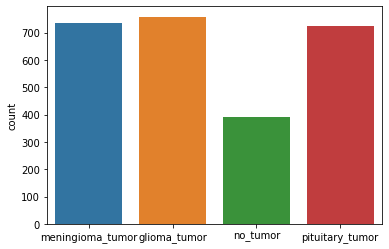

In [10]:
sns.countplot(y_train)

C:\Users\sipsm\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:ylabel='count'>

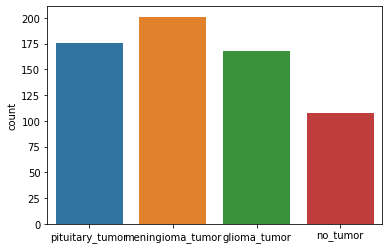

In [11]:
sns.countplot(y_test)

In [12]:
y_train_new = []
for i in y_train:
    y_train_new.append(labels.index(i))
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)


y_test_new = []
for i in y_test:
    y_test_new.append(labels.index(i))
y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)

In [13]:
effnet = EfficientNetB1(weights='imagenet',include_top=False,input_shape=(image_size,image_size,3))

In [17]:
prediction = Dense(len(folders), activation='softmax')(x)

In [18]:
model = effnet.output
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dropout(rate=0.5)(model)
model = tf.keras.layers.Dense(4,activation='softmax')(model)
model = tf.keras.models.Model(inputs=effnet.input, outputs = prediction)

In [16]:
from glob import glob
folders = glob('Training/*')

In [15]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
x = Flatten()(effnet.output)

In [19]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 224, 224, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 224, 224, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 225, 225, 3)  0           normalization[0][0]              
_______________________________________________________________________________________

In [20]:
model.compile(loss='categorical_crossentropy',optimizer = 'Adam', metrics= ['accuracy'])

In [21]:
tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint("effnet.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 2, min_delta = 0.001,
                              mode='auto',verbose=1)

# **Training The Model**

In [ ]:
history = model.fit(X_train,y_train,validation_split=0.1, epochs =7, verbose=1, batch_size=32,
                   callbacks=[tensorboard,checkpoint,reduce_lr])

In [ ]:
get_acc = history.history['accuracy']
value_acc = history.history['val_accuracy']
get_loss = history.history['loss']
validation_loss = history.history['val_loss']

epochs = range(len(get_acc))
plt.plot(epochs, get_acc, 'r', label='Accuracy of Training data')
plt.plot(epochs, value_acc, 'b', label='Accuracy of Validation data')
plt.title('Training vs validation accuracy')
plt.legend(loc=0)
plt.figure()
plt.show()

In [ ]:
epochs = range(len(get_loss))
plt.plot(epochs, get_loss, 'r', label='loss of Training data')
plt.plot(epochs, validation_loss, 'b', label='loss of Validation data')
plt.title('Training vs validation loss')
plt.legend(loc=0)
plt.figure()
plt.show()

In [ ]:
from tensorflow.keras.models import load_model

model.save('model_efficient_b1.h5')

# **Prediction**

In [ ]:
pred = model.predict(X_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)

# **Evaluation**

In [ ]:
print(classification_report(y_test_new,pred))

In [ ]:
fig,ax=plt.subplots(1,1,figsize=(14,7))
sns.heatmap(confusion_matrix(y_test_new,pred),ax=ax,xticklabels=labels,yticklabels=labels,annot=True,
           cmap='summer',alpha=0.7,linewidths=2,linecolor='black')
fig.text(s='Confusion Matrix for Brain Tumour Segmentation',size=18,fontweight='bold',
             fontname='monospace',color='red',y=0.92,x=0.28,alpha=0.8)

plt.show()

In [ ]:
pred

In [ ]:
IMAGE_SIZE = [224, 224]

dataset=tf.keras.preprocessing.image_dataset_from_directory ("Testing",
                                            shuffle=True,
                                           image_size=(IMAGE_SIZE),
                                           batch_size=50
                                           )

In [ ]:
class_names= dataset.class_names
class_names
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
for image_batch,labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())
    for i in range(12):
        ax=plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")